## Economic Dispatch

Economic dispatch is a classic problem in power systems operation, where a system operator is interested in minimizing the operating costs subject to some set of physical constraints on the units. Here we use the most basic example where units have stable operating regions between their minimum power output, $p_{min}$, and their maximum power output, $p_{max}$. We also use $f_i(p_i)$ to represent the operating cost of a generating unit. The collective power output of all generating units must be capable of satisfy the total demand the system, $d$.

$$\min \sum \limits _{i}^{N} f_i(p_i)$$

$$s.t. \sum \limits _{i}^{N}p_i = d$$

$$p_{min} \le p_i \le p_{max}, \hspace{0.1cm} \forall i \in N $$

Cost functions $f_i(p_i)$ are usually represented as quadratic functions of the form:
$$f_i(p_i) = \frac{a_i}{2}p_i^2 + b_ip_i + c_i$$

where $a_k$, $b_k$, $c_k$ are fit from data. Let's see how we can solve this using Python.

In [1]:
import numpy as np
import cvxpy as cvx
import pandas as pd
import matplotlib.pyplot as plt
from typing import List

import warnings
warnings.filterwarnings('ignore')

## Problem Setup:
Suppose we have a system consisting of six units, with attributes described below, and a total instantaneous load of 1200 MW. For simplicity, we've set the constants $c_k$ to zero.

In [2]:
units = pd.DataFrame(
    {
        "number": ["1", "2", "3", "4", "5", "6"],
        "pmin": [10, 10, 35, 35, 125, 130],
        "pmax": [125, 150, 210, 225, 315, 325],
        "a": [0.305, 0.212, 0.071, 0.057, 0.036, 0.042],
        "b": [35.539, 46.160, 38.308, 40.397, 38.270, 36.328],
        "c": [0, 0, 0, 0, 0, 0],
        "alpha": [0.0084, 0.0084, 0.0136, 0.0136, 0.0092, 0.0092],
        "beta": [0.328, 0.328, -0.545, -0.545, -0.511, -0.511]
    }
)
units

,number,pmin,pmax,a,b,c,alpha,beta
0,1,10,125,0.305,35.539,0,0.0084,0.328
1,2,10,150,0.212,46.160,0,0.0084,0.328
2,3,35,210,0.071,38.308,0,0.0136,-0.545
3,4,35,225,0.057,40.397,0,0.0136,-0.545
4,5,125,315,0.036,38.270,0,0.0092,-0.511
5,6,130,325,0.042,36.328,0,0.0092,-0.511


We're interested in finding the optimal set points for each generating unit, which we designate here as the vector $p$. We also set the demand $d$ to 1,200 MW.

In [3]:
p = cvx.Variable(len(units))
d = 1200

Next we build the objective function, the constraints, and instantiate the model. Finally, we solve the problem.

In [4]:
objective = cvx.Minimize(1/2 * cvx.quad_form(p, np.diag(units.a.values)) + units.b.values * p + units.c.values)
constraints = [sum(p) >= d, p >= units.pmin.values, p <= units.pmax.values]
model = cvx.Problem(objective, constraints)
model.solve()
print('Successfully solved the economic dispatch problem!')

Successfully solved the economic dispatch problem!


In [5]:
units['dispatch'] = p.value
units['loading'] = units.dispatch / units.pmax * 100

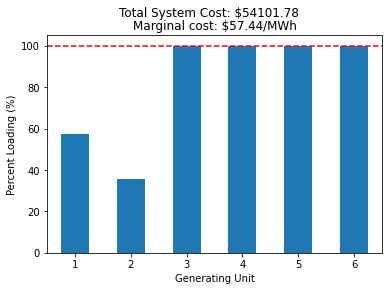

In [6]:
units.plot.bar(x='number', y='loading', legend=None)
plt.xticks(rotation=0)
plt.xlabel("Generating Unit")
plt.ylabel("Percent Loading (%)")
plt.axhline(y=100, color='r', linestyle='--')
plt.suptitle(f'Total System Cost: ${round(objective.value, 2)}')
plt.title(f'Marginal cost: ${round(float(constraints[0].dual_value), 2)}/MWh')
plt.show()

## Environmental Dispatch
* Tradeoff between economic and environmental dispatch

Text(0, 0.5, 'Environmental')

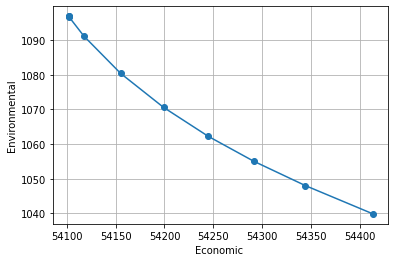

In [9]:
def pareto(xi):
    p = cvx.Variable(6)
    f_ecn = 1/2 * cvx.quad_form(p, np.diag(units.a.values)) + units.b.values @ p
    f_env = 1/2 * cvx.quad_form(p, np.diag(units.alpha.values)) + units.beta.values @ p
    fo = cvx.Minimize(xi * f_ecn + (1-xi) * f_env)
    res = [sum(p) >= d, p>=units.pmin.values, p<=units.pmax.values]
    model = cvx.Problem(fo, res)
    model.solve()
    return [f_ecn.value, f_env.value]

points = 10
F_ecn = np.zeros(points)
F_env = np.zeros(points)
for k in range(points):
    xi = 1 / (k+1)
    F_ecn[k], F_env[k] = pareto(xi)

plt.plot(F_ecn, F_env, marker='o')
plt.grid()
plt.xlabel('Economic ')
plt.ylabel('Environmental')

## Economic Dispatch + Basic Transportation Model

In [11]:
ng = 6  # number of generators
nl = 9  # number of lines
nn = 6  # number of nodes
p = cvx.Variable(len(units))
d = [0, 800, 0, 0, 400, 0]  # demand at each node
Lambda = (0, 0, 2, 2, 3, 5) # generator locations
Omega = ((0, 1), (0, 1), (0, 3), (0, 4), (1, 2), (1, 5), (2, 5), (3, 4), (4, 5)) # lines
smax = nl * [300]   # max flow of each line

s = cvx.Variable(nl)    # power flows

EqB = nn * [0]  # balances

for j, omega in enumerate(Omega):
    k, m = omega
    EqB[k] += s[j]  # flow leaving from k
    EqB[m] += -s[j] # flow arriving to k

for k, gennode in enumerate(Lambda):
    EqB[gennode] += -p[k]

res = [p >= units.pmin.values, p <= units.pmax.values, s <= smax, -s <= smax]

for k in range(nn):
    res += [EqB[k] + d[k] == 0]

obj = 1/2 * cvx.quad_form(p, np.diag(units.a.values)) + units.b.values * p
model = cvx.Problem(cvx.Minimize(obj), res)
model.solve()

54101.78523029992

## Linearized Power Flow

In [26]:
ng = 6  # number of generators
nl = 9  # number of lines
nn = 6  # number of nodes
p = cvx.Variable(len(units))
d = [0, 800, 0, 0, 400, 0]  # demand at each node
Lambda = (0, 0, 2, 2, 3, 5) # generator locations
Omega = ((0, 1), (0, 1), (0, 3), (0, 4), (1, 2), (1, 5), (2, 5), (3, 4), (4, 5)) # lines
smax = nl * [300]   # max flow of each line

s = cvx.Variable(nl)    # power flows

EqB = nn * [0]  # balances

for j, omega in enumerate(Omega):
    k, m = omega
    EqB[k] += s[j]  # flow leaving from k
    EqB[m] += -s[j] # flow arriving to k

for k, gennode in enumerate(Lambda):
    EqB[gennode] += -p[k]

res = [p >= units.pmin.values, p <= units.pmax.values, s <= smax, -s <= smax]

for k in range(nn):
    res += [EqB[k] + d[k] == 0]

snom = 100
x = nl * [0.02]
th = cvx.Variable(nn)   # nodal angles
res += [th[0] == 0]     # angle reference

for j, omega in enumerate(Omega):
    k, m = omega
    res += [x[j] * s[j] == snom*(th[k] - th[m])]


obj = 1/2 * cvx.quad_form(p, np.diag(units.a.values)) + units.b.values * p
model = cvx.Problem(cvx.Minimize(obj), res)
model.solve()

54762.709585048426

## Unit Commitment

In [13]:
df = pd.DataFrame(
    {
        "a": [0.0004984, 0.001246, 0.00623],
        "b": [16.821, 40.620, 21.93],
        "c": [220.42, 161.86, 171.20],
        "c_up": [124.69, 249.22, 0],
        "z_ini": [1, 1, 0],
        "pmax": [220, 100, 20],
        "pmin": [100, 10, 10]
    }
)

d = np.array([178, 168, 161, 157, 158, 163, 176, 
194, 209, 221, 233, 240, 247, 248, 253, 260, 261, 251, 250, 242, 242, 231, 205, 200])

In [25]:
T = len(d)
n = len(df.a)
zeta = cvx.Variable((n, T), boolean=True)
mu = cvx.Variable((n, T), boolean=True)
delta = cvx.Variable((n, T), boolean=True)
p = cvx.Variable((n,T))

fop = 0
fsup  = 0
res = []
for t in range(T):
    for k in range(n):
        fop = fop + df.a[k] * p[k, t]**2 + df.b[k] + p[k, t] + df.c[k] + zeta[k, t]
        fsup = fsup + df.c_up[k] * mu[k, t]
        res += [p[k, t] >= df.pmin[k] * zeta[k, t]]
        res += [p[k, t] <= df.pmax[k] * zeta[k, t]]

for t in range(T):
    res += [cvx.sum(p[:,t]) == d[t]]

for t in range(1, T):
    for k in range(n):
        res += [mu[k, t] - delta[k, t] == zeta[k, t] - zeta[k, t-1]]
        res += [mu[k, t] + delta[k, t] <= 1]

for k in range(n):
    res += [mu[k, 0] - delta[k, 0] == zeta[k, 0] - df.z_ini[k]]
    res += [mu[k, 0] + delta[k, 0] <= 1]

obj = cvx.Minimize(fop + fsup)
model = cvx.Problem(obj, res)
model.solve()

SolverError: Either candidate conic solvers (['GLPK_MI']) do not support the cones output by the problem (SOC, NonNeg, Zero), or there are not enough constraints in the problem.

In [32]:
d = (137, 139, 136, 129, 129, 141, 165, 200, 224, 232, 223, 231, 223, 220, 213, 207, 213, 214, 224, 228, 224, 212, 185, 159)

a = (10, 9, 8, 7, 7, 7, 8, 9, 10, 10, 10, 9, 8, 8, 8, 8, 8, 9, 9, 9, 9, 9, 9, 9)

pH = cvx.Variable(24)   # power hydro unit
pT = cvx.Variable(24)   # power thermal unit
q = cvx.Variable(24)    # water discharge
s = cvx.Variable(24)    # spillage
v = cvx.Variable(25)    # volume

cost = 0

res = [v[0] == 150, v[24] == 80]

for t in range(24):
    cost = cost + 19.2 * pT[t]
    res += [pH[t] == 8.5 * q[t]]
    res += [pH[t] + pT[t] == d[t]]
    res += [80 <= v[t], v[t] <= 150]
    res += [0 <= pT[t], pT[t] <= 250]
    res += [0 <= pH[t], pH[t] <= 150]
    res += [s[t] >= 0]
    res += [v[t+1] == v[t] + a[t] - s[t] -q[t]]

model = cvx.Problem(cvx.Minimize(cost), res)
model.solve()

43267.19999806679

## Solar + Storage + Thermal + Grid Purchase

In [52]:
pS = [0, 0, 0, 0, 0, 0, 0, 26, 50, 71, 87, 97, 100, 97, 87, 71, 50, 26, 0, 0, 0, 0, 0, 0] # solar forecast
c = [0.4, 0.4, 0.4, 0.4, 0.4, 0.5, 0.6, 0.6, 0.6, 0.5, 0.5, 0.4, 0.4, 0.4, 0.5, 0.5, 0.6, 0.9, 1.1, 1.1, 1.0, 0.8, 0.7, 0.5]    # price forecast

vup = cvx.Variable(25, nonneg=True)     # upper reservoir volume
vdw = cvx.Variable(25, nonneg=True)     # lower reservoir volume
pgen = cvx.Variable(24, nonneg=True)    # generation mode for pumped hydro
ppmp = cvx.Variable(24, nonneg=True)    # storage mode for pumped hydro
pthm = cvx.Variable(24, nonneg=True)    # thermal power plant

q = cvx.Variable(24)    # outflow for pumped hydro
p = cvx.Variable(24)    # net trade to grid
x = cvx.Variable(24, boolean=True)    # storage or generation mode for pumped hydro
f = 0   # initial cost
res = [vup[0] == 0, vdw[0] == 120]  # initial conditions

for t in range(24):
    f = f + c[t] * p[t] - 0.95 * pthm[t]    # obj function
    res += [vup[t] <= 120, vdw[t] <= 120]   # max storage in MWh
    res += [pgen[t] - 0.8 * ppmp[t] == q[t]]    # pumped hydro efficiency
    res += [pgen[t] - ppmp[t] + pS[t] + pthm[t] == p[t]]   # total power
    res += [pgen[t] <= 30 * x[t], ppmp[t] <= 30 * (1-x[t])]      # max power output of pumped hydro
    res += [vup[t+1] == vup[t] - q[t]]  # time link for upper reservoir
    res += [vdw[t+1] == vdw[t] + q[t]]  # time link for lower reservoir
    res += [pthm[t] <= 10]  # max thermal capacity

model = cvx.Problem(cvx.Maximize(f), res)
model.solve()



448.3

Long-step dual simplex will be used
